## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2025)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset.
    - Extended YaleB dataset.
    - AR dataset (**optional**).
+ Perform Evaluation.
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 1. Load Dataset

### 1.0 Data Folder

In [16]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset zip stored in Drive
zip_path = "/content/drive/MyDrive/comp4328/a1/data.zip"

# Unzip into Colab local filesystem
!unzip -q "$zip_path" -d /content/data

# Inspect structure
!ls -R /content/data | head -20


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/data/data/CroppedYaleB/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: /content/data:
data
__MACOSX

/content/data/data:
CroppedYaleB
ORL

/content/data/data/CroppedYaleB:
yaleB01
yaleB02
yaleB03
yaleB04
yaleB05
yaleB06
yaleB07
yaleB08
yaleB09
yaleB10
yaleB11


In [17]:
# The structure of data folder.
!ls -l data

total 8
drwx------ 4 root root 4096 Aug 25  2018 data
drwxrwxr-x 3 root root 4096 Aug 25  2018 __MACOSX


In [39]:
# CONFIG - adjust these as the settings
import numpy as np

config = {
    "dataset": "ORL",             # "ORL" or "YALE"
    "normalization": "per_image",  # "none" or "per_image" or "global"
    "noise_scalar": 0.2,
    "nmf_type": "Frobenius",            # "Frobenius" or "L21"
    "rank": "auto",               # shared dimension between W and H. Set as an int or as "auto" to be num of classes in Y
    "max_iterations": 10000,
    "tol": 1e-5,                  # Tolerance, allows for early stopping
    "seed": 0,                    # the seeding for RNG. Allows consistent replication
    "reduce_ORL": 1,              # Reduction factor. ORL pics are smaller so maybe reduce less
    "reduce_YALE": 3,             # YALE pics are larger so can reduce more
    "epsilon": 1e-12
}


rng = np.random.default_rng(config["seed"])
eps = config["epsilon"]

### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [40]:
import os
import numpy as np
from PIL import Image

def load_data(root='/content/data/data/CroppedYaleB', reduce=3, normalization="none", eps=1):
    """
    Load ORL (or Extended YaleB) dataset to numpy array.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.

    """
    images, labels = [], []
    height, width = 0, 0

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):

            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue

            if not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.


            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # save the height/width after resizing
            if (height == 0 or width == 0):
              height = img.size[1]
              width = img.size[0]


            # TODO: preprocessing.

            # convert image to numpy array.
            # img = np.asarray(img).reshape((-1,1))
            img = np.asarray(img, dtype=np.float32)

            # normalzation per image
            if normalization == "per_image":
              img = (img - img.min()) / (img.max() - img.min() + eps)

            img = img.reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    # normalize globally
    if normalization == "global":
      images = images.astype(np.float32)
      images = images / 255.0 # normalizing them


    return images, labels, height, width

In [9]:
# Just to test/retrieve values

# Load ORL dataset.
X, Y, h, w = load_data(root='/content/data/data/ORL', reduce=3)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

# Load Extended YaleB dataset.
X, Y, h, w = load_data(root='/content/data/data/CroppedYaleB', reduce=3)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

ORL dataset: X.shape = (1110, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (3584, 2414), Y.shape = (2414,)


In [41]:
# salt and pepper noise
def add_sp_noise(V_hat, p, r, rng=None):

  if rng is None:
    rng = np.random.default_rng()

  m, n = V_hat.shape # n images, each has m pixels in a flat vector

  V_noisy = V_hat.copy()

  for i in range(n): #iterate through each image
    for j in range(m): #iterate through each pixel
      if rng.random() < p: #we modify the pixel
        if rng.random() < r: # we turn the pixel white
          V_noisy[j, i] = 1.0 # turn the pixel white
        else:
          V_noisy[j, i] = 0.0 # turn the pixel black

  return V_noisy




---------------------------


## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


Loading ORL dataset ...
V_hat.shape=(10304, 400), Y_hat.shape=(400,)
Image count =  400
Dimensions after reduction:
	height =  112
	width =  92
Flattened image vector length =  10304
Number of unique labels in Y =  40


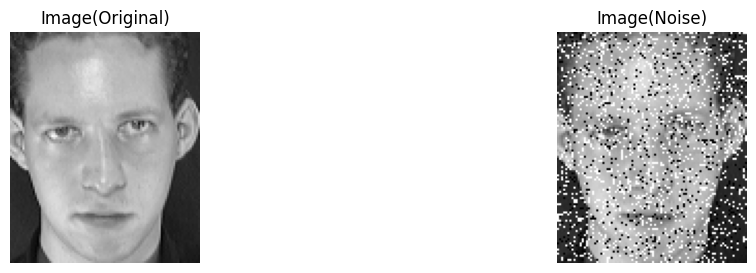

In [43]:
# Load dataset.
print(f"Loading {config['dataset']} dataset ...")
if config["dataset"] == "ORL":
  V_hat, Y_hat, h, w = load_data(root='/content/data/data/ORL', reduce=config["reduce_ORL"], normalization=config["normalization"])
elif config["dataset"] == "YALE":
  V_hat, Y_hat, h, w = load_data(root='/content/data/data/CroppedYaleB', reduce=config["reduce_YALE"], normalization=config["normalization"])
else:
  raise ValueError(f"Unkown dataset in config: {config['dataset']}")

print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))
print("Image count = ", V_hat.shape[1])
print("Dimensions after reduction:")
print("\theight = ", h)
print("\twidth = ", w)
print("Flattened image vector length = ", V_hat.shape[0])
print("Number of unique labels in Y = ", len(set(Y_hat)))

# check if h*w = pixel count after reduction
if (h*w != V_hat.shape[0]):
  raise ValueError(f"h*w =/= pixel count\nhw = {h*w}\nV_hat.shape[0] = {V_hat.shape[0]}")
  exit(1)



# Plot Result
import matplotlib.pyplot as plt
ind = 2
plt.figure(figsize=(10,3))
plt.subplot(131); plt.imshow(V_hat[:, ind].reshape(h, w), cmap="gray"); plt.title("Image(Original)"); plt.axis("off")

# Add Noise
# V_noise = rng.random(V_hat.shape) * config["noise_scalar"]
# V = V_hat + V_noise

V = add_sp_noise(V_hat, 0.2, 0.7)

# plt.subplot(132); plt.imshow(V_noise[:, ind].reshape(h, w), cmap="gray"); plt.title("Noise"); plt.axis("off")
plt.subplot(133); plt.imshow(V[:, ind].reshape(h, w), cmap="gray"); plt.title("Image(Noise)"); plt.axis("off")
plt.show()


In [37]:
# Defining NMF Funtions

# FSE method
def frobenius_squared_error(V, W, H):
    WH = W @ H
    return np.sum((V - WH) ** 2)

def rre_fse(V_hat, W, H, eps=1e-12): # V_hat is the clean matrix (pre-noise)
  WH = W @ H
  FE = np.linalg.norm( V_hat - WH, ord='fro')
  denom = np.linalg.norm(V_hat, ord='fro')
  RRE = FE / (denom + eps)
  return RRE

def fse_mur(V, W, H, max_iterations, eps=1e-12):
  print("Starting FSE MUR training...")
  errors = []
  prev = None

  iterations_done = 0

  for it in range(max_iterations):
      numerator_H = W.T @ V
      denominator_H = (W.T @ W @ H)

      H = H * numerator_H / (denominator_H + eps)

      numerator_W = V @ H.T
      denominator_W = (W @ H @ H.T)

      W = W * numerator_W / (denominator_W + eps)

      training_error = frobenius_squared_error(V, W, H)
      errors.append(training_error)
      iterations_done += 1

      if (iterations_done%100) == 0:
        print(f"Completed {iterations_done} iterations out of {max_iterations}")
        print(f"\t Training error = {training_error:.2f}")

      # check for early stopping
      if prev is None:
        prev = training_error
        continue

      if prev is not None:
        rel = abs(training_error - prev) / (abs(prev) + eps)
        if rel < config["tol"]: # if the curve has flattened too much or is going up
          print("Early stopping at iteration: ", it) # stop
          break
        prev = training_error


  print(f"Completed {iterations_done} iterations")

  return W, H, errors

# L2,1 Norm method

def l21_norm(V, W, H): # finds the L_2,1 Norm objective function result
    R = V - W @ H
    return np.linalg.norm(R, axis=0).sum(0) #axis =0 means we go column by column

def compute_u(V, WH, eps=1e-12): # computes u the vector instead of matrix U. Faster calculations
    R = V - WH
    col_norms = np.linalg.norm(R, axis=0) # gets a vector of all the norms of the columns of R
    u = 1.0 / np.maximum(col_norms, eps) # inverts them
    return u

def rre_l21_norm(V_hat, W, H, eps=1e-12):
  R = V_hat - W @ H
  nom = np.linalg.norm(R, axis=0).sum(0)
  denom = np.linalg.norm(V_hat, axis=0).sum(0)
  RRE = nom / (denom + eps)
  return RRE

def l21_norm_mur(V, W, H, max_iterations, eps=1e-12, delta=1e-12): # does the H update and W update steps for L21 NMF
  print("Staring L2,1 Norm NMF MUR training...")
  errors = []
  prev = None
  iterations_done = 0

  for it in range(max_iterations):
      # precompute some variables to save runtime
      WH = W @ H
      u = compute_u(V, WH, eps=eps) # finds u but as a vector, not full diagonal matrix U
      V_u = V * u

      numerator_H = W.T @ (V_u)
      denominator_H = W.T @ (WH * u) + delta # includes delta to avoid division by zero

      H *= numerator_H / denominator_H # updates H
      H = np.maximum(H, 0) # clips it to keep it non-negative

      WH = W@H # recompute now that we've updated H

      numerator_W = (V_u) @ H.T
      denominator_W = (WH * u) @ H.T + delta

      W *= numerator_W / denominator_W # updates W
      W = np.maximum(W, 0) # clips it to keep it non-negative

      training_error = l21_norm(V, W, H)
      errors.append(training_error) # tracks the objective function value at each update step
      iterations_done += 1

      if (iterations_done%100) == 0:
        print(f"Completed {iterations_done} iterations out of {max_iterations}")
        print(f"\tTraining error = {training_error:.2f}")

      # check for early stopping
      if prev is None:
        prev = training_error
        continue

      if prev is not None:
        rel = abs(training_error - prev) / (abs(prev) + eps)
        if rel < config["tol"]: # if the curve has flattened too much or is going up
          print("Early stopping at iteration: ", it) # stop
          break
        prev = training_error


  print(f"Completed {iterations_done} iterations")
  return W, H, errors



In [38]:
# Initialisation
if config["rank"] == "auto":
  rank = len(set(Y_hat))
elif isinstance(config["rank"], int):
  rank = config["rank"]
else:
  raise ValueError(f"Error! config rank must be an integer or auto. It is currently {config['rank']}")

print("rank = ", rank)

# randomly initialise the values of W and H
W_0 = rng.random((V.shape[0], rank))
H_0 = rng.random((rank, V.shape[1]))

print(f"starting W dimensions: {V.shape[0]} x {rank}")
print(f"starting H dimensions: {rank} x {V.shape[1]}")

# optional
# print("starting W = \n", W_0)
# print("starting H = \n", H_0)

rank =  40
starting W dimensions: 2576 x 40
starting H dimensions: 40 x 400


In [39]:
# call the NMF algorithm and output the RRE (dependant on which NMF algorithm)
import time
start = time.time()

if config["nmf_type"] == "Frobenius":
  W, H, errors = fse_mur(V, W_0, H_0, max_iterations=config["max_iterations"])
  end = time.time()
  RRE = rre_fse(V_hat, W, H)
  print(f"FSE RRE = {RRE:.6f}")

elif config["nmf_type"] == "L21":
  W, H, errors = l21_norm_mur(V, W_0, H_0, max_iterations=config["max_iterations"])
  end = time.time()
  RRE = rre_l21_norm(V_hat, W, H)
  print(f"L2,1 Norm RRE = {RRE:.6f}")
else:
  raise ValueError(f"Unkown NMF type selected in config: {config['nmf_type']}")
  exit(1)

print(f"Training completed in {end - start:.2f} seconds")
# previous way for time
# Early stopping at iteration:  1247
# Completed 1248 iterations
# L2,1 Norm RRE = 0.217566
# Training completed in 262.24 seconds

# after some tweaks
# Early stopping at iteration:  1226
# Completed 1227 iterations
# L2,1 Norm RRE = 0.217306
# Training completed in 90.11 seconds

# FSE Yale = 560 seconds


#FSE ORL - 66.76 secs
#FSE ORL without error calc - 45.12



Starting FSE MUR training...
Completed 100 iterations out of 10000
	 Training error = 501076499.61
Completed 200 iterations out of 10000
	 Training error = 387167571.25
Completed 300 iterations out of 10000
	 Training error = 356934429.42
Completed 400 iterations out of 10000
	 Training error = 344794623.81
Completed 500 iterations out of 10000
	 Training error = 338642952.13
Completed 600 iterations out of 10000
	 Training error = 334981503.19
Completed 700 iterations out of 10000
	 Training error = 332555214.11
Completed 800 iterations out of 10000
	 Training error = 330822047.23
Completed 900 iterations out of 10000
	 Training error = 329508483.20
Completed 1000 iterations out of 10000
	 Training error = 328460068.24
Completed 1100 iterations out of 10000
	 Training error = 327587018.89
Completed 1200 iterations out of 10000
	 Training error = 326844025.27
Completed 1300 iterations out of 10000
	 Training error = 326198125.06
Completed 1400 iterations out of 10000
	 Training error =

In [40]:
# Optional - Printing the final W, H, WH, and normalised W

print("final H = \n", np.round(H, 2))
print("final W = \n", np.round(W, 2))
print("final WH = \n", np.round((W @ H), 2))
W_norm = W / (W.sum(axis=1, keepdims=True) + eps) # let's us see the relative influence of the weight matrix elements
print("W-Norm = \n", np.round(W_norm, 2))

final H = 
 [[4.860e+00 3.000e-02 9.520e+00 ... 0.000e+00 0.000e+00 4.760e+00]
 [1.880e+00 3.350e+00 9.640e+00 ... 2.661e+01 2.047e+01 1.158e+01]
 [8.780e+00 8.800e+00 8.130e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [1.524e+01 2.880e+00 0.000e+00 ... 1.321e+01 4.810e+00 1.000e-02]
 [3.864e+01 2.430e+00 1.129e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 6.500e+00 3.730e+00 ... 0.000e+00 0.000e+00 6.130e+00]]
final W = 
 [[0.   1.04 0.   ... 0.11 0.19 0.01]
 [0.   1.2  0.   ... 0.13 0.2  0.02]
 [0.   1.19 0.   ... 0.23 0.27 0.12]
 ...
 [0.73 0.   0.   ... 0.   0.83 0.  ]
 [0.81 0.   0.   ... 0.   0.78 0.  ]
 [0.96 0.   0.   ... 0.   0.91 0.  ]]
final WH = 
 [[ 66.43  67.62  63.28 ... 133.44 129.52 129.22]
 [ 61.89  64.72  61.83 ... 134.84 130.59 130.06]
 [ 69.41  65.92  63.39 ... 133.83 127.77 127.29]
 ...
 [137.25  57.5   58.46 ...  91.4  100.4   71.3 ]
 [127.49  36.28  45.35 ...  96.9  106.1   74.2 ]
 [126.3   36.18  39.59 ...  96.34 106.02  76.48]]
W-Norm = 
 [[0.   0.07 0.  

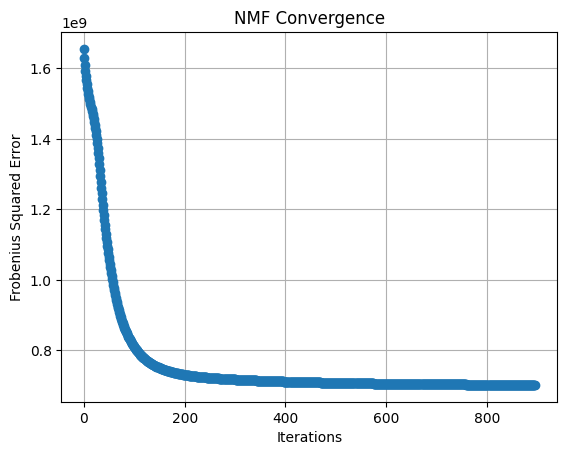

In [23]:
# plot the errors

plt.plot(errors, marker='o')
plt.xlabel("Iterations")
if config["nmf_type"] == "Frobenius":
  plt.ylabel("Frobenius Squared Error")
elif config["nmf_type"] == "L21":
  plt.ylabel("L21 Norm Error")
plt.title("NMF Convergence")
plt.grid(True)
plt.show()

### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [41]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    print("Num of classes = ", len(set(Y)))
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

print('==> Evaluate Acc and NMI ...')

# Assign cluster labels.
Y_pred = assign_cluster_label(H.T, Y_hat)

acc = accuracy_score(Y_hat, Y_pred)
nmi = normalized_mutual_info_score(Y_hat, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))


==> Evaluate Acc and NMI ...
Num of classes =  40
Acc(NMI) = 0.7400 (0.8617)


h =  56
w =  46


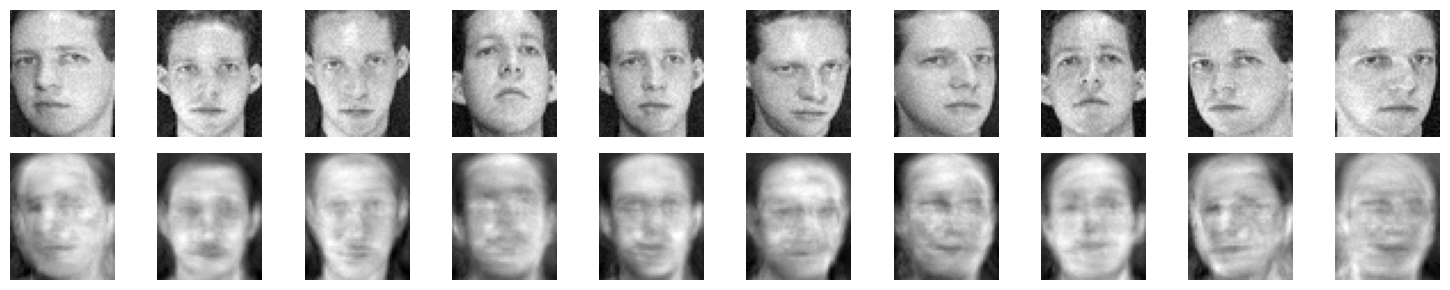

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reconstructions(V, W, H, h=None, w=None, n_images=10):
    """
    Plot a few original images and their reconstructions side by side.

    V : (m, n) data matrix (each column is a flattened image)
    W, H : NMF factors (V ≈ W @ H)
    h, w : image height and width (optional; inferred if not provided)
    n_images : number of images to display
    """
    m, n = V.shape
    V_hat = W @ H






    n_images = min(n_images, n)
    fig, axes = plt.subplots(2, n_images, figsize=(1.5*n_images, 3))

    for i in range(n_images):
        # Original
        axes[0, i].imshow(V[:, i].reshape(h, w), cmap="gray")
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_ylabel("Original", fontsize=12)

        # Reconstruction
        axes[1, i].imshow(V_hat[:, i].reshape(h, w), cmap="gray")
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_ylabel("Reconstructed", fontsize=12)

    plt.tight_layout()
    plt.show()


# hardcoding these for now
# h = 56
# w = 46

print("h = ", h)
print("w = ", w)
plot_reconstructions(V, W, H, h, w, n_images=10)


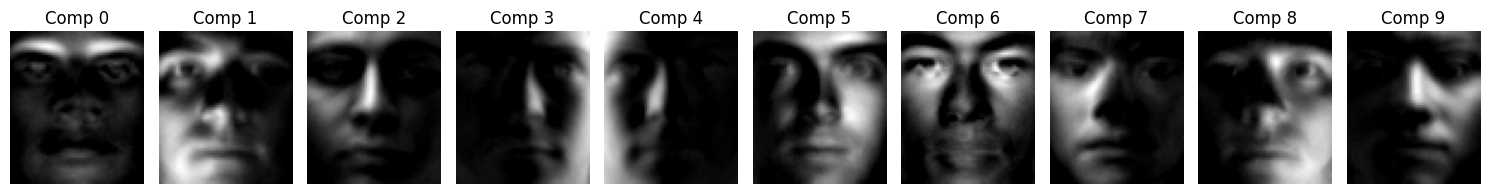

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Known original (height, width) pairs before reduction
_KNOWN_HW = [(112, 92),  # ORL
             (192, 168)] # Extended YaleB (cropped)

def _infer_hw_from_num_pixels(m):
    """Given m = h*w after reduction, infer (h,w) by matching known originals."""
    for H0, W0 in _KNOWN_HW:
        for r in range(1, max(H0, W0)+1):
            if (H0 % r == 0) and (W0 % r == 0):
                h, w = H0 // r, W0 // r
                if h * w == m:
                    return h, w
    raise ValueError(f"Could not infer (h,w) for {m} pixels. "
                     f"Add your dataset's original (H0,W0) to _KNOWN_HW.")

def plot_basis_images(W, V_hat=None, h=None, w=None, n_components=20):
    """
    Plot first n_components columns of W as images.
    If h,w not provided, infer from V_hat (preferred) or from W's row count.
    """
    if h is None or w is None:
        m = (V_hat.shape[0] if V_hat is not None else W.shape[0])
        h, w = _infer_hw_from_num_pixels(int(m))

    k = W.shape[1]
    n = min(n_components, k)

    fig, axes = plt.subplots(1, n, figsize=(1.5*n, 2))
    if n == 1:
        axes = [axes]
    for i in range(n):
        ax = axes[i]
        ax.imshow(W[:, i].reshape(h, w), cmap="gray")
        ax.set_title(f"Comp {i}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


plot_basis_images(W, V_hat=V_hat, n_components=20)
